In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
from scipy.spatial import distance
import time
from IPython.display import clear_output
from scipy.spatial import Delaunay

Let $X = \{X_i\}_{i \ge 1}$ be a homogeneous Poisson point process with intensity 1 on $\mathbb{R}^2$. The following function returns one realization of the Poisson points in a square. The size of the square is $n$ plus a value dependent on the distances of the points in the inner square. The array <code>x</code> conatains the points in the inner square and the array <code>z</code> the points in the outer envelope.

In [2]:
def onePath(n):
    #Generate points in the inner square
    numberOfPointsInInnerSquare = 0
    while numberOfPointsInInnerSquare <= 1:
        numberOfPointsInInnerSquare = np.random.poisson(n*n)
    xCoordinates = np.random.uniform(0,n,numberOfPointsInInnerSquare)
    yCoordinates = np.random.uniform(0,n,numberOfPointsInInnerSquare)
    x = np.vstack((xCoordinates, yCoordinates)).T
    
    #Calculate the required length bounds for the outer square
    addOnDistanceToSquare = 2.25
    
    #Divide the outer square setminus the inner square in 4 rectangles and generate points in each rectangle
    numberOfPointsInOuterRectangles = []
    for i in range(2):
        numberOfPointsInOuterRectangles.append(np.random.poisson(n*addOnDistanceToSquare))
    for i in range(2):
        numberOfPointsInOuterRectangles.append(np.random.poisson((n+2*addOnDistanceToSquare)*addOnDistanceToSquare))
    xCoordinates = np.random.uniform(-addOnDistanceToSquare,0,numberOfPointsInOuterRectangles[0])
    yCoordinates = np.random.uniform(0,n,numberOfPointsInOuterRectangles[0])
    xCoordinates = np.append(xCoordinates,np.random.uniform(n,n+addOnDistanceToSquare,numberOfPointsInOuterRectangles[1]))
    yCoordinates = np.append(yCoordinates,np.random.uniform(0,n,numberOfPointsInOuterRectangles[1]))
    xCoordinates = np.append(xCoordinates,np.random.uniform(-addOnDistanceToSquare,n+addOnDistanceToSquare,numberOfPointsInOuterRectangles[2]))
    yCoordinates = np.append(yCoordinates,np.random.uniform(-addOnDistanceToSquare,0,numberOfPointsInOuterRectangles[2]))
    xCoordinates = np.append(xCoordinates,np.random.uniform(-addOnDistanceToSquare,n+addOnDistanceToSquare,numberOfPointsInOuterRectangles[3]))
    yCoordinates = np.append(yCoordinates,np.random.uniform(n,n+addOnDistanceToSquare,numberOfPointsInOuterRectangles[3]))
    z = np.vstack((xCoordinates, yCoordinates)).T
    return x, z

Scatter of a random realization.

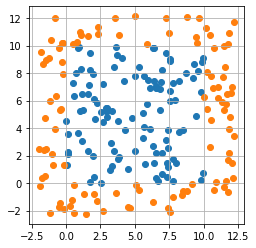

In [3]:
x,z = onePath(10)
plt.scatter(x.T[0],x.T[1])
plt.scatter(z.T[0],z.T[1])
plt.gcf().gca().set_aspect('equal')
plt.grid()
plt.show()

Executing the function <code>onePath(n)</code> over some number of paths.

In [4]:
np.random.seed(1234)
numberOfPaths = 10000
n = 10
alpha = 15


def rng(coordinates_inner, coordinates_outer):
    g = nx.Graph()
    for x, y in coordinates_inner:
        g.add_node((x, y), x=x, y=y)
    for x, y in coordinates_outer:
        g.add_node((x, y), x=x, y=y)
    nodes = []
    for x in g.nodes():
        nodes.append([x[0],x[1]])
    
    delaunay = Delaunay(nodes)
    
    for triangles in delaunay.simplices:
        potentialEdges = []
        for j in range(3):
            potentialEdges.append(nodes[triangles[j]])
        for j in range(3):
            c1 = potentialEdges[j % 3]
            c2 = potentialEdges[(j+1) % 3]
            g.add_edge((c1[0],c1[1]), (c2[0],c2[1]), weight = 0)
 
    h = g.copy()
    for c1,c2 in g.edges():
        d = distance.euclidean(c1, c2)
        for possible_blocker in h.nodes():
            distToC1 = distance.euclidean(possible_blocker, c1)
            distToC2 = distance.euclidean(possible_blocker, c2)
            if distToC1 < d and distToC2 < d:
                # this node is in the lune and blocks
                h.remove_edge(c1, c2)
                break
            else:
                if c1 in coordinates_inner:
                    h.remove_edge(c1, c2)
                    h.add_edge(c1, c2, weight = d**alpha)
    return h


# generate some random coordinates
G = []
start = time.time()
for i in range(numberOfPaths):
    clear_output(wait=True)
    coordinates_inner, coordinates_outer = onePath(n)
    G.append(rng(coordinates_inner, coordinates_outer))
    print("current progress:",i+1,"/",numberOfPaths)

H = []
for i in range(numberOfPaths):
    H.append(G[i].size(weight="weight"))

end = time.time()
print("Elapsed time: " + str(end - start) + " seconds")

current progress: 10000 / 10000
Elapsed time: 33843.10607099533 seconds


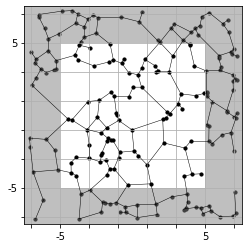

In [5]:
indexH = H.index(sorted(H)[len(H)-1])
nodes = []
edges = []
for x in G[indexH].nodes():
    nodes.append([x[0],x[1]])
    
plt.scatter([x[0] for x in nodes],[x[1] for x in nodes], color='black', s=10)
plt.gcf().gca().set_aspect('equal')
plt.grid()
plt.xlim([-2.5, 12.5])
plt.xticks(ticks=[-2,0, 2, 4, 6, 8, 10,12], labels =["",-5,"","","","",5,""])
plt.ylim([-2.5, 12.5])
plt.yticks([-2,0, 2, 4, 6, 8, 10,12], labels =["",-5,"","","","",5,""])
plt.axvspan(10,13, color='grey', alpha=0.5, lw=0)
plt.axvspan(-3,0, color='grey', alpha=0.5, lw=0)
plt.axhspan(ymin=10, ymax=13, xmin=1/6, xmax=5/6, color='grey', alpha=0.5, lw=0)
plt.axhspan(ymin=-3, ymax=0, xmin=1/6, xmax=5/6, color='grey', alpha=0.5, lw=0)

for e1, e2 in G[indexH].edges():
    edges.append([[e1[0],e1[1]],[e2[0],e2[1]]])
    plt.plot([e1[0],e2[0]],[e1[1],e2[1]], color='black',lw=.5)
    
plt.show()

Creating Tikz picture

In [ ]:
indexH = H.index(sorted(H)[len(H)-2])
points = []
edges = []
for x in G[indexH].nodes():
    points.append([x[0],x[1]])
for e1, e2 in G[indexH].edges():
    if e1[0] != e2[0] or e1[1] != e2[1]:
        edges.append([[e1[0],e1[1]],[e2[0],e2[1]]])

numberOfLenses = 3
starts = []
radii = []
angles = []
F = G[indexH].copy()
for i in range(numberOfLenses):
    maxEdge = None
    maxWeight = 0
    for e in F.edges():
        weight = F.get_edge_data(*e)["weight"]
        if weight > maxWeight:
            maxWeight = weight
            maxEdge = e
    maxWeight = maxWeight**(1/alpha)
    if maxEdge[0][0] - maxEdge[1][0] >= 0 and maxEdge[0][1] - maxEdge[1][1] >= 0:
        print("1")
        angles.append(np.arccos((maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi)+180)
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    elif maxEdge[0][0] - maxEdge[1][0] < 0 and maxEdge[0][1] - maxEdge[1][1] < 0:
        print("2")
        angles.append(np.arccos(-(maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    elif maxEdge[0][0] - maxEdge[1][0] >= 0 and maxEdge[0][1] - maxEdge[1][1] < 0:
        print("3")
        angles.append(180-np.arccos((maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    else:
        print("4")
        angles.append(-(np.arccos(-(maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi)))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    print(maxWeight)
    print(angles[i])
    print(maxEdge)
    F.remove_edge(*maxEdge)
    
borders_string = ["\\fill[fill=gray!20] (-2.5,-2.5) rectangle ++(2.5,15);\n","\\fill[fill=gray!20] (0,-2.5) rectangle ++(10,2.5);\n",
                  "\\fill[fill=gray!20] (10,-2.5) rectangle ++(2.5,15);\n","\\fill[fill=gray!20] (0,10) rectangle ++(10,2.5);\n"]

points_string = ["\\fill ({0:1.2f}, {1:1.2f}) circle (2pt);\n".format(points[i][0], points[i][1])
                 for i in range(len(points))]

edges_string = ["\\draw ({0:1.2f}, {1:1.2f}) -- ({2:1.2f}, {3:1.2f});\n".format(edges[i][0][0],edges[i][0][1],edges[i][1][0],edges[i][1][1])
                for i in range(len(edges))]

lenses_string = ["\draw[red] ({1:1.2f},{2:1.2f}) arc[start angle={0:1.2f}-60,delta angle=2*60,radius={3:1.2f}] arc[start angle=180+{0:1.2f}-60,delta angle=2*60,radius={3:1.2f}] -- cycle;\n".format(angles[i], starts[i][0], starts[i][1], radii[i])
                for i in range(len(radii))]

tikz = ''.join(borders_string + points_string + edges_string + lenses_string)
tikz = '\\begin{tikzpicture}\n' + tikz + '\\end{tikzpicture}\n'

fname = 'largeRNNgraph.tex'

f = open(fname, "w")
f.write(tikz)
f.close()

!pdflatex evolFig.tex

4
3.3671379649532347
-31.73922466992873
((1.4359759922301851, 3.799721700888038), (4.2995624220638105, 2.028425329892455))
3
2.208483491244788
165.40990973586028
((0.05121906671577414, 5.968033357915067), (-2.086046912550299, 6.524354726345764))
2
2.1982291972879997
64.28814754338345
((2.1831908276423553, 8.040086522058935), (3.136882620224328, 10.020663096839932))


In [7]:
indexH = 1
points = []
edges = []
for x in G[indexH].nodes():
    points.append([x[0],x[1]])
for e1, e2 in G[indexH].edges():
    if e1[0] != e2[0] or e1[1] != e2[1]:
        edges.append([[e1[0],e1[1]],[e2[0],e2[1]]])

numberOfLenses = 3
starts = []
radii = []
angles = []
F = G[indexH].copy()
for i in range(numberOfLenses):
    maxEdge = None
    maxWeight = 0
    for e in F.edges():
        weight = F.get_edge_data(*e)["weight"]
        if weight > maxWeight:
            maxWeight = weight
            maxEdge = e
    maxWeight = maxWeight**(1/alpha)
    if maxEdge[0][0] - maxEdge[1][0] >= 0 and maxEdge[0][1] - maxEdge[1][1] >= 0:
        print("1")
        angles.append(np.arccos((maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi)+180)
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    elif maxEdge[0][0] - maxEdge[1][0] < 0 and maxEdge[0][1] - maxEdge[1][1] < 0:
        print("2")
        angles.append(np.arccos(-(maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    elif maxEdge[0][0] - maxEdge[1][0] >= 0 and maxEdge[0][1] - maxEdge[1][1] < 0:
        print("3")
        angles.append(180-np.arccos((maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    else:
        print("4")
        angles.append(-(np.arccos(-(maxEdge[0][0]-maxEdge[1][0])/maxWeight)*360/(2*math.pi)))
        starts.append([maxEdge[0][0]+maxWeight*np.cos((angles[i]-60)/360*2*math.pi),maxEdge[0][1]+maxWeight*np.sin((angles[i]-60)/360*2*math.pi)])
        radii.append(maxWeight)
    print(maxWeight)
    print(angles[i])
    print(maxEdge)
    F.remove_edge(*maxEdge)
    
borders_string = ["\\fill[fill=gray!20] (-2.5,-2.5) rectangle ++(2.5,15);\n","\\fill[fill=gray!20] (0,-2.5) rectangle ++(10,2.5);\n",
                  "\\fill[fill=gray!20] (10,-2.5) rectangle ++(2.5,15);\n","\\fill[fill=gray!20] (0,10) rectangle ++(10,2.5);\n"]

points_string = ["\\fill ({0:1.2f}, {1:1.2f}) circle (2pt);\n".format(points[i][0], points[i][1])
                 for i in range(len(points))]

edges_string = ["\\draw ({0:1.2f}, {1:1.2f}) -- ({2:1.2f}, {3:1.2f});\n".format(edges[i][0][0],edges[i][0][1],edges[i][1][0],edges[i][1][1])
                for i in range(len(edges))]

lenses_string = ["\draw[red] ({1:1.2f},{2:1.2f}) arc[start angle={0:1.2f}-60,delta angle=2*60,radius={3:1.2f}] arc[start angle=180+{0:1.2f}-60,delta angle=2*60,radius={3:1.2f}] -- cycle;\n".format(angles[i], starts[i][0], starts[i][1], radii[i])
                for i in range(len(radii))]

tikz = ''.join(borders_string + points_string + edges_string + lenses_string)
tikz = '\\begin{tikzpicture}\n' + tikz + '\\end{tikzpicture}\n'

fname = 'typicalRNNgraph.tex'

f = open(fname, "w")
f.write(tikz)
f.close()

!pdflatex evolFig.tex

4
2.0698601800085785
-88.30983731891682
((7.619738930361532, 3.3548022716525807), (7.680788681442614, 1.285842607309633))
2
1.9317053981103838
64.79817024563066
((5.23102313610054, 8.649817885471704), (6.05355910990421, 10.397650920085606))
1
1.8506742313871125
243.03455070864976
((2.161863031600805, 3.5931506248110234), (1.3226690286735276, 1.9436814568144911))
^C
